In [2]:
"""
Collect Data: Capture and label images of our handwriting.
    [ ] Chelsey
    [ ] Shawn
    [X] Starter data set (MNIST)
    [X] Starter data set (EMNIST ByClass)

Preprocess Data: Resize, normalize, and encode the images and labels.

Build a CNN Model: Use Keras to define a CNN suitable for image classification.
Train the Model: Fit the model on your handwriting dataset.
Evaluate and Predict: Assess model accuracy and use it to predict new handwriting samples.
"""

import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import pickle
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

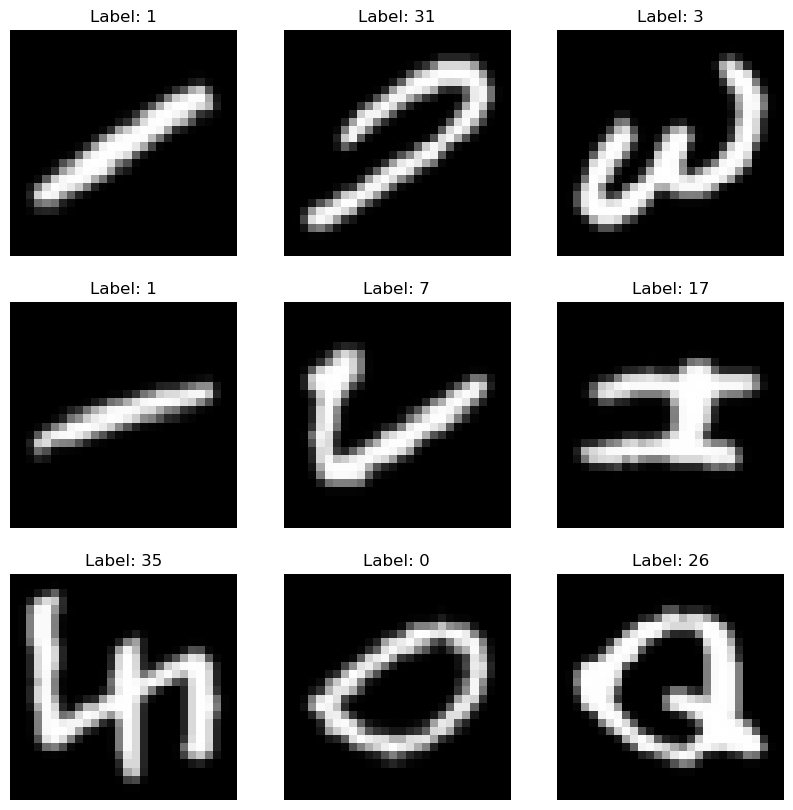

Epoch 1/5


c:\Users\shawn\anaconda3\envs\dev\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21811/21811 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.7088 - loss: 1.0088 - val_accuracy: 0.8113 - val_loss: 0.5673
Epoch 2/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7890 - loss: 0.6582 - val_accuracy: 0.8156 - val_loss: 0.5472
Epoch 3/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7959 - loss: 0.6308 - val_accuracy: 0.8213 - val_loss: 0.5332
Epoch 4/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7992 - loss: 0.6195 - val_accuracy: 0.8234 - val_loss: 0.5293
Epoch 5/5
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.8013 - loss: 0.6146 - val_accuracy: 0.8219 - val_loss: 0.5312
3636/3636 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8224 - loss: 0.5239
Test Accuracy: 0.82


In [7]:
# Load the EMNIST Letters dataset
(train_ds, test_ds), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Function to visualize some samples
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap="gray")
        plt.title(f"Label: {label.numpy()}")
        plt.axis('off')
    plt.show()

# Plot some samples from the training dataset
plot_samples(train_ds)

# Preprocessing function to normalize the images
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Prepare the datasets for training and evaluation
train_ds = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(63, activation='softmax')  # 62 classes for 10 digits + 26 uppercase + 26 lowercase
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_ds, epochs=5, validation_data=test_ds)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

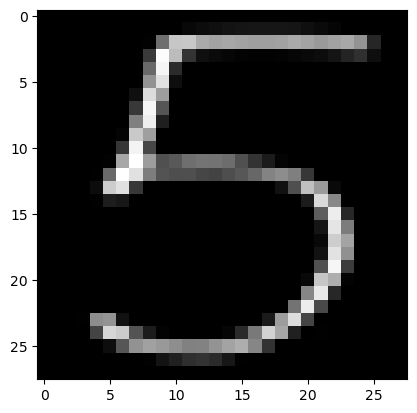

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Character: W
Prediction confidence: 0.16


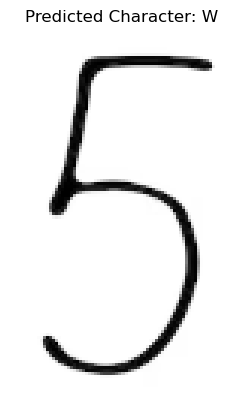

In [17]:
# source image
image_path = "Resources/Test Images/test5.png"

# Define the class mapping for EMNIST ByClass
emnist_byclass_labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',   # Digits 0-9
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',  # Uppercase A-Z
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'   # Lowercase a-z
]

# Define the image preprocessing function (similar to how it was done for the dataset)
def preprocess_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path).convert('L')  # Convert to grayscale if needed
    img = ImageOps.invert(img) # Invert the image colors if the background is white and digits are black 
    img = img.resize((28, 28))  # Resize to 28x28 pixels (same as EMNIST)
    
    plt.imshow(img, cmap='gray') 
    plt.show()

    # Convert the image to a NumPy array and normalize it
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = img_array.reshape(1, 28, 28, 1)  # Reshape to (1, 28, 28, 1) for batch dimension
    
    return img_array

# Function to make a prediction on a single image
def predict_image(model, image_path):
    processed_image = preprocess_image(image_path)
    
    # Get model prediction (output probabilities for each class)
    predictions = model.predict(processed_image)
    
    # Find the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    return predicted_class, predictions

# Function to decode predicted class index to character
def decode_prediction(predicted_class):
    return emnist_byclass_labels[predicted_class]

# Example usage:
predicted_class, predictions = predict_image(model, image_path)
predicted_character = decode_prediction(predicted_class)

print(f"Predicted Character: {predicted_character}")
print(f"Prediction confidence: {predictions[0][predicted_class]:.2f}")

# Visualize the image for confirmation
plt.imshow(np.array(Image.open(image_path)), cmap='gray')
plt.title(f"Predicted Character: {predicted_character}")
plt.axis('off')
plt.show()